# Transiente Hidráulico em um sistema Reservatório-tubo-válvula

**Informações sobre a topologia**

- O reservatório no extremo de montante possui nível d’água fixo na cota $100 m$;
- a adutora possui extensão total de $1500 m$,
- diâmetro interno de $1 m$;
- fator de atrito pode ser admitido como sendo igual a $0,020$ para condições de escoamento permanente e de escoamento transitório.
- A adutora pode ser considerada como assentada na horizontal na cota zero. 
- A velocidade média em escoamento permanente é de $1 m/s$;
- velocidade de propagação da onda de pressão (celeridade) é de $1000 m/s$;
- O escoamento transitório é provocado pelo fechamento da válvula na extremidade de jusante, que é especificado por $\tau = (1 – \frac{t}{t_c})^{3}$, em que $tc = \frac{2L}{a}$, sendo $L$ a extensão da adutora e $a$ a celeridade.

# Códigos e Resultados

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
#Condições físicas
#Adutora na horizontal na cota zero

#constantes universais
g = 9.81
pi = 3.141592
#Infos do sistema
H0 = 100 #Carga do regime permanente em m
L = 1500 #Comprimento da tubulação em m
D = 1 #diametro interno em m
fat = 0.020 #Fator de atrito para o escoamento Permanente e transitório
A = pi*(D**2)/4 #Área em m²
Vm = 1 #velocidade média em regime permanente em m/s
Q0 = Vm*A #Vazão no regime permanente em m³/s
a = 1000 #m/s (celeridade)
tc = 2*L/a
tt = 60 #tempo total em segundos
dx = 10 #delta espaço
dt = dx/a  #delta tempo seguindo a condição de courant
Nt = int(tt/dt) #Número de valores no tempo
Nx = int(L/dx) #Número de valores no espaço
print( "Nt=", Nt )
print("Nx=", Nx)

B = a/(g*A) #ImpedÂncia Característica
R = (fat*dx)/(2*g*D*A**2) # Coeficiente de resistÊncia

Nt= 6000
Nx= 150


In [3]:
#Criando Matrizes de dados
H = np.ones((Nt+1,Nx+1))*H0
Q = np.ones((Nt+1,Nx+1))*Q0

t=1
Time_list = [0] # lista para Armazenar intervalo de tempo

H[:,0] = H0 #Condição de contorno, pressão no trecho mais a jusante constante

for x in range(len(H[0,:])):
    H[0,x] = H0 - (Q0**2*fat*x*dx)/(2*g*A**2*D)

for i in np.arange(dt,60+dt,dt): #i representa o tempo em cada delta_t
  #Condições de Montante
  Bb = B + R*np.abs(Q[t-1,1])
  Cb = H[t-1,1] - B * Q[t-1,1]
  Q[t,0] = (H0-Cb)/Bb

  x = 1
  for s in np.arange(dx,L,dx):
    
    #Nós internos
    Ca= H[t-1,x-1] + B*Q[t-1,x-1]
    Cb= H[t-1,x+1] - B * Q[t-1,x+1]
    Ba = B + R*np.abs(Q[t-1,x-1])
    Bb = B + R*np.abs(Q[t-1,x+1])
    Q[t,x] = (Ca-Cb)/(Ba+Bb)
    H[t,x] = ((Bb*Ca)+(Ba*Cb))/(Ba+Bb)
    x=x+1

  #Condições de jusante
  if i < tc:
    Ba = B + R*np.abs(Q[t-1,Nx-1])
    Ca = H[t-1,Nx-1] + B*Q[t-1,Nx-1]
    tau = (1-i/tc)**3
    Cv = ((Q0*tau)**2)/(2*H[0,Nx])
    Q[t,Nx] = -Ba*Cv + np.sqrt((Ba*Cv)**2+2*Cv*Ca)
    H[t, Nx] = Ca - Ba*Q[t,Nx]
  else:
    Ba = B + R*np.abs(Q[t-1,Nx-1])
    Ca = H[t-1,Nx-1] + B*Q[t-1,Nx-1]
    tau = 0 #Quando i = tc, (1-i/tc) é igual a zero
    Cv = ((Q0*tau)**2)/(2*H[0,Nx])
    Q[t,Nx] = -Ba*Cv + np.sqrt((Ba*Cv)**2+2*Cv*Ca)
    H[t, Nx] = Ca - Ba*Q[t,Nx]

  Time_list.append(i+dt)

  t=t+1

Valvula = pd.DataFrame({'Tempo':Time_list, 'Vazao(m3/s)':Q[:,Nx],"Carga (m)": H[:,Nx] })
Secao_750 = pd.DataFrame({"Tempo":Time_list, "Vazao(m3/s)":Q[:,75], "Carga (m)": H[:,75]})

# Gráficos

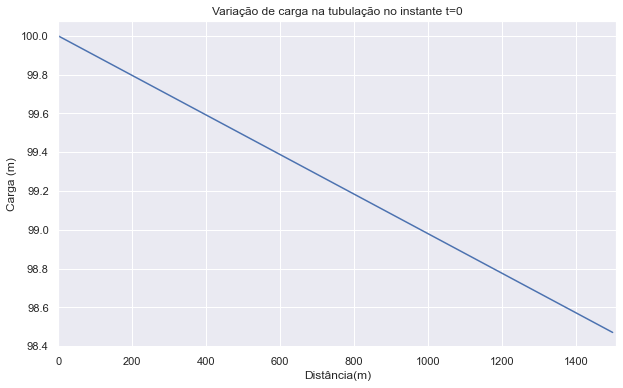

In [4]:
sns.set_theme()
f, ax = plt.subplots(figsize=(10,6))
xa = np.arange(0,1510,10)
ya = H[0,:]
sns.lineplot(x=xa, y = ya)
plt.title('Variação de carga na tubulação no instante t=0')
plt.xlabel('Distância(m)')
plt.ylabel('Carga (m)')
ax.set_xlim(0,1510)
f.savefig('Carga_inicial.png', dpi = 400);

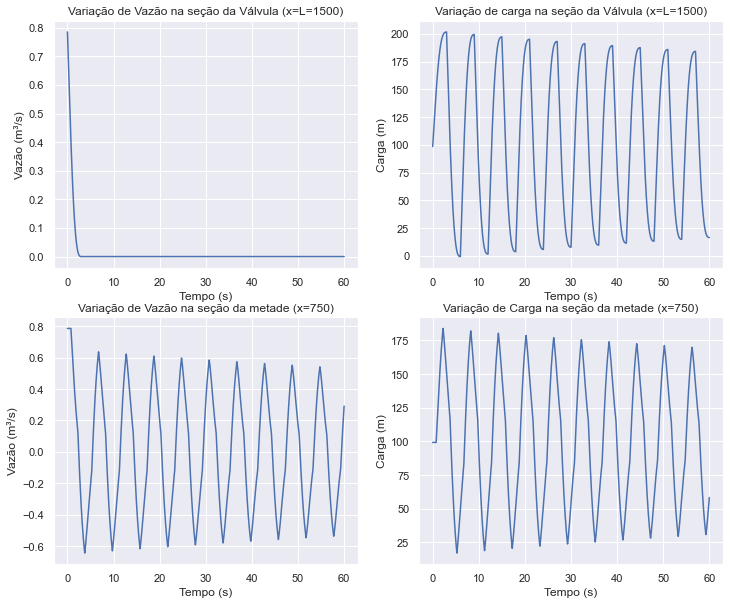

In [5]:
f, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize=(12,10))
ax1.plot(Valvula['Tempo'], Valvula['Vazao(m3/s)'])
ax1.set_ylabel('Vazão (m³/s)')
ax1.set_xlabel('Tempo (s)')
ax1.set_title('Variação de Vazão na seção da Válvula (x=L=1500)')

ax2.plot(Valvula['Tempo'], Valvula['Carga (m)'])
ax2.set_ylabel('Carga (m)')
ax2.set_xlabel('Tempo (s)')
ax2.set_title('Variação de carga na seção da Válvula (x=L=1500)')

ax3.plot(Secao_750['Tempo'], Secao_750['Vazao(m3/s)'])
ax3.set_ylabel('Vazão (m³/s)')
ax3.set_xlabel('Tempo (s)')
ax3.set_title('Variação de Vazão na seção da metade (x=750)')

ax4.plot(Secao_750['Tempo'], Secao_750['Carga (m)'])
ax4.set_ylabel('Carga (m)')
ax4.set_xlabel('Tempo (s)')
ax4.set_title('Variação de Carga na seção da metade (x=750)')

f.tight_layout;
f.savefig('Transiente.png', dpi = 400)

# Vídeo com variação dos valores no tempo

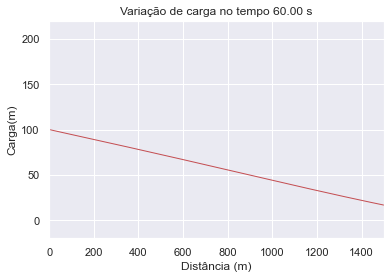

In [6]:
import numpy as np
import matplotlib
# matplotlib.use("Agg")
import matplotlib.pyplot as plt
import matplotlib.animation as animation
# Settings
video_file = "Video_Variacao_pressao_vel_real.mp4"
clear_frames = True # Should it clear the figure between each frame?
fps = 100
# Output video writer
FFMpegWriter = animation.writers['ffmpeg']
metadata = dict(title='Movie Test', artist='Matplotlib', comment='Movie support!')
writer = FFMpegWriter(fps=fps, metadata=metadata)
fig = plt.figure()
x = np.arange(0,1510,10)
t=0
y=[]
with writer.saving(fig, video_file, 100):
    for i in np.arange(0,60.01,0.01):
        y.append(H[t,:])
        if clear_frames:
            fig.clear()
        plt.title(f"Variação de carga no tempo {i:.{2}f} s")
        plt.ylabel("Carga(m)")
        plt.xlabel("Distância (m)")
        plt.ylim((-20,220))
        plt.xlim((0,1500))
        ax, = plt.plot(x, y[t], 'r-', linestyle="solid", linewidth=1)
        writer.grab_frame()
        t+=1